

# Project: Show and No-Show Patients

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> The goal of this report is to describe the data analysis process performed over the **Medical Appointments No Shows** dataset published by Kaggle in https://www.kaggle.com/joniarroba/noshowappointments/data. At the end of the document we will try to answer the following questions:

>  1) Do **Waiting Days** affect to the next appointment impact patients _Show Up_ rate?

>  2) Does **Age** of patients have and effect on their _Show Up_ rate?

>  3) How does receiving **SMS** helps patients to increase their _Show Up Rate_?
 
>  4) Is the **Neighbourhood** a relevant feature of each patient that affect the _Show Up Rate_ 

#### Importing libraries

In [154]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns
import scipy.stats as scs

Populating the interactive namespace from numpy and matplotlib


<a id='wrangling'></a>
## Data Wrangling


### General Properties

Loading the data and performing a visual inspection of _column names_ and _row values_.

In [155]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('data/noshowappointments-kagglev2-may-2016.csv',header=0)

In [156]:
df.head(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No
6,7.336882e+14,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.449833e+12,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No
9,7.812456e+13,5629123,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No


### Data Cleaning

The data cleaning to be executed over the dataframe considers the following steps:

#### 1) Normalizing dates **Scheduled** and **Appointment** in the format mm/dd/yyyy.

>As time is not consistent between ScheduledDay and AppointmentDay, we will drop the timestamp on the dataframe for each columns.

In [157]:
df['ScheduledDay'] = pd.DatetimeIndex(df['ScheduledDay']).normalize()

df['AppointmentDay'] = pd.DatetimeIndex(df['AppointmentDay']).normalize()

df[['ScheduledDay','AppointmentDay']].head(5)

,ScheduledDay,AppointmentDay
0,2016-04-29,2016-04-29
1,2016-04-29,2016-04-29
2,2016-04-29,2016-04-29
3,2016-04-29,2016-04-29
4,2016-04-29,2016-04-29


#### 2) Add column **WaitingDays**:

> * Exclude _same day appointments_ and inconsistent data with **WaitingDays** less than ZERO.

In [158]:
df['WaitingDays']=df['AppointmentDay']-df['ScheduledDay']
df['WaitingDays'] = df['WaitingDays'].dt.days
df['WaitingDays'] = df['WaitingDays'].clip(lower=0, upper=None)

### Checking for outliers and duplicated records
> Additionally, we will examine the statistical summary of the dataframe to check for outliers.

In [159]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,WaitingDays
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,10.183792
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,15.254924
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000


The _describe()_ function help us to identify non valid values for each columns.

3)  Clip **Age** values less than zero to 0


In [160]:
#Removing ages values less than zero.
#Clip all values in Age column that are lower than ZERO to ZERO.
df['Age'] = df['Age'].clip(lower=0, upper=None)

#### 4) We will verify if **DUPLICATED DATA** is present in the dataset by checking:

> 4.a) Unique **PatientId** counts in the same _AppointmentDay_: The same patient on the same day is considered duplicated data.
> 
>> 4.a.1) Group them by **AppointmentDay** and **PatientID** to count appointments per patient per day and select those ones that have more than one appointment per day.


In [161]:
#AppointmentDay
#AppointmentID
temp_df = df.groupby(['AppointmentDay','PatientId']).count()
print temp_df['AppointmentID'].head(5)
temp_df = temp_df[temp_df['AppointmentID'] > 1]

print temp_df['AppointmentID'].head(5)

AppointmentDay  PatientId  
2016-04-29      253866521.0    1
                318385314.0    1
                422861257.0    1
                522886422.0    1
                744463183.0    1
Name: AppointmentID, dtype: int64
AppointmentDay  PatientId   
2016-04-29      9.673878e+08    2
                3.183717e+09    2
                4.497415e+09    2
                8.435224e+09    3
                1.484468e+10    2
Name: AppointmentID, dtype: int64


>> 4.a.2) Save all **PatientId** values on a list:

In [162]:
temp_df = zip(*temp_df.index.values)
patientId_list = list(temp_df[1])
print patientId_list[1:10]

[3183716914.0, 4497415116.0, 8435223536.0, 14844682413.0, 15347269128.0, 19252634865.0, 38962632722.0, 45555578626.0, 56548277857.0]


>> 4.a.3) From the original dataframe (initial load) we will extract all **PatientId** records from the **patientId_list** list.

In [163]:
sameday_patient_df =df[df['PatientId'].isin(patientId_list)]

>> 4.a.4) We sort by _'AppointmentDay', 'PatientId','AppointmentID'_ in ASCENDING order to visually inspect the **sameday_patient_df** dataframe and decide if it is necessary or not to remove duplicated values.

In [164]:
#sameday_patient_df.sort_values(by=['AppointmentDay', 'PatientId','AppointmentID'],ascending =[1,1,1])
sameday_patient_df = sameday_patient_df.sort_values(by=['AppointmentDay', 'PatientId','AppointmentID'],ascending =[1,1,1])
print sameday_patient_df[['AppointmentDay','PatientId','AppointmentID','No-show']].head(20)

     AppointmentDay     PatientId  AppointmentID No-show
2040     2016-04-29  9.673878e+08        5621683      No
2034     2016-04-29  9.673878e+08        5621688      No
1676     2016-04-29  3.183717e+09        5521207      No
1673     2016-04-29  3.183717e+09        5521208      No
371      2016-04-29  4.497415e+09        5600825      No
370      2016-04-29  4.497415e+09        5600826      No
3054     2016-04-29  8.435224e+09        5639113      No
3070     2016-04-29  8.435224e+09        5641049      No
3112     2016-04-29  8.435224e+09        5642784      No
1929     2016-04-29  9.943729e+09        5591000      No
1708     2016-04-29  1.362198e+10        5562486      No
2580     2016-04-29  1.456915e+10        5534604      No
1355     2016-04-29  1.484468e+10        5631661      No
2275     2016-04-29  1.484468e+10        5641298      No
1246     2016-04-29  1.534727e+10        5620065      No
1245     2016-04-29  1.534727e+10        5620070      No
1231     2016-04-29  1.826376e+

>> 4.a.5) **Removing duplicated values** from the original dataframe 

In [165]:
df.duplicated(subset=['AppointmentDay','PatientId']).sum()

8719

>    8719 duplicates from a total of 110527 represents the 7.89% of the sample. As is meaningful, we will proceed to drop duplicated records.

>    Dataframe is sorted by 'AppointmentDay', 'PatientId','AppointmentID','No-show'.
I decide to sort the no-show column in _ascending order_ to pick the SHOW values if there is an inconsistency between SHOW and NO-SHOW.

In [166]:
df = df.sort_values(by=['AppointmentDay', 'PatientId','AppointmentID','No-show'],ascending =[1,1,1,1])
df = df.drop_duplicates(subset=['AppointmentDay','PatientId'])
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,WaitingDays
count,1.018080e+05,1.018080e+05,101808.000000,101808.000000,101808.000000,101808.000000,101808.000000,101808.000000,101808.000000,101808.000000
mean,1.465136e+14,5.674067e+06,37.058925,0.097654,0.198295,0.072568,0.027621,0.021717,0.345160,10.490178
std,2.548138e+14,7.176537e+04,23.214083,0.296848,0.398717,0.259427,0.163884,0.159653,0.475423,15.426518
min,3.921784e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.156429e+12,5.639186e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.153383e+13,5.679526e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,9.429574e+13,5.724260e+06,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000


#### 5) Create **Show** and **No-Show** columns

In [167]:
def stringToValueByColumn(x,flag):
    
    if(x ==flag):
        return 1
    else:
        return 0
        
#Over the 'No-Show' column, apply the stringToValue() function. 
df['Show']=df['No-show'].apply(stringToValueByColumn,args=('No',))
df['No_Show']=df['No-show'].apply(stringToValueByColumn,args=('Yes',))
df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingDays,Show,No_Show
1792,253866521.0,5563137,M,2016-04-08,2016-04-29,53,BENTO FERREIRA,0,1,0,0,0,1,No,21,1,0
706,318385314.0,5559991,F,2016-04-08,2016-04-29,31,JESUS DE NAZARETH,0,0,0,0,0,1,No,21,1,0
1831,422861257.0,5638450,F,2016-04-29,2016-04-29,30,CRUZAMENTO,1,0,0,0,0,0,No,0,1,0
463,522886422.0,5633872,F,2016-04-28,2016-04-29,66,SÃO CRISTÓVÃO,0,1,1,0,0,0,Yes,1,0,1
117,744463183.0,5539219,F,2016-04-01,2016-04-29,34,SANTO ANTÔNIO,1,0,0,0,0,1,No,28,1,0


### Creating 3 Samples Group

After cleaning and wrangling the data, we will create three groups (dataframes) to analyze the behavior of patients. The three groups are:

+ Always Show Patients.
    - Patients that never missed an appointment - **TOTAL of 64,265 (63.11 %)**


In [168]:
a = df.groupby('PatientId')['No_Show','Show'].sum()
a = a[a['No_Show'] > 0]
show_noshow_patients = a[a['Show'] > 0 ]
shownoshow_df =df[df['PatientId'].isin(show_noshow_patients.index.tolist())]

+ Always No-Show Patients
    - Patients that missed all appointments - **TOTAL of 9,619 (9.47 %)**

In [169]:
a = df.groupby('PatientId')['No_Show','Show'].sum()
a = a[a['No_Show'] > 0]
noshow_patients = a[a['Show'] == 0]
noshow_df =df[df['PatientId'].isin(noshow_patients.index.tolist())]

+ Show and No-Show Patients.
    - Patients that both assist and missed appointments - **TOTAL of 27,924 (27.42 %)**

In [170]:
a = df.groupby('PatientId')['No_Show','Show'].sum()
a = a[a['No_Show'] == 0]
show_patients = a[a['Show'] > 0]
show_df =df[df['PatientId'].isin(show_patients.index.tolist())]

In [171]:
print "SHOW and NO SHOW patients"
print shownoshow_df.describe()

SHOW and NO SHOW patients
          PatientId  AppointmentID           Age   Scholarship  Hipertension  \
count  2.792400e+04   2.792400e+04  27924.000000  27924.000000  27924.000000   
mean   1.416361e+14   5.673408e+06     36.366781      0.115922      0.189514   
std    2.511447e+14   6.643749e+04     22.006440      0.320137      0.391924   
min    6.485121e+07   5.030230e+06      0.000000      0.000000      0.000000   
25%    3.855963e+12   5.640736e+06     18.000000      0.000000      0.000000   
50%    2.898551e+13   5.677565e+06     36.000000      0.000000      0.000000   
75%    9.164749e+13   5.719546e+06     53.000000      0.000000      0.000000   
max    9.996275e+14   5.790464e+06    115.000000      1.000000      1.000000   

           Diabetes    Alcoholism       Handcap  SMS_received   WaitingDays  \
count  27924.000000  27924.000000  27924.000000  27924.000000  27924.000000   
mean       0.074130      0.031084      0.022919      0.384472     10.253474   
std        0.261

In [172]:
print "SHOW patients"
print show_df.describe()

SHOW patients
          PatientId  AppointmentID           Age   Scholarship  Hipertension  \
count  6.426500e+04   6.426500e+04  64265.000000  64265.000000  64265.000000   
mean   1.483142e+14   5.679364e+06     37.922119      0.088400      0.208652   
std    2.562595e+14   7.147202e+04     23.834894      0.283877      0.406348   
min    3.921784e+04   5.134220e+06      0.000000      0.000000      0.000000   
25%    4.219226e+12   5.644153e+06     17.000000      0.000000      0.000000   
50%    3.191252e+13   5.684445e+06     38.000000      0.000000      0.000000   
75%    9.488922e+13   5.730968e+06     57.000000      0.000000      0.000000   
max    9.999816e+14   5.790484e+06    115.000000      1.000000      1.000000   

           Diabetes    Alcoholism       Handcap  SMS_received   WaitingDays  \
count  64265.000000  64265.000000  64265.000000  64265.000000  64265.000000   
mean       0.074053      0.025862      0.022220      0.310496      9.408761   
std        0.261859      0.1

In [173]:
print "NO SHOW patients"
print noshow_df.describe()

NO SHOW patients
          PatientId  AppointmentID          Age  Scholarship  Hipertension  \
count  9.619000e+03   9.619000e+03  9619.000000  9619.000000   9619.000000   
mean   1.486429e+14   5.640588e+06    33.301175     0.106456      0.154590   
std    2.555405e+14   7.912060e+04    21.952174     0.308436      0.361532   
min    5.628261e+06   5.122866e+06     0.000000     0.000000      0.000000   
25%    4.173945e+12   5.597326e+06    15.500000     0.000000      0.000000   
50%    3.284838e+13   5.644209e+06    31.000000     0.000000      0.000000   
75%    9.598093e+13   5.694654e+06    50.000000     0.000000      0.000000   
max    9.996585e+14   5.789979e+06    97.000000     1.000000      1.000000   

          Diabetes   Alcoholism      Handcap  SMS_received  WaitingDays  \
count  9619.000000  9619.000000  9619.000000   9619.000000  9619.000000   
mean      0.058114     0.029317     0.014866      0.462626    18.402329   
std       0.233971     0.168702     0.136374      0.498

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

>**RUBRIC**
> **Is the data explored in many ways? ** The project investigates the stated question(s) from multiple angles. At least three variables are investigated using both single-variable (1d) and multiple-variable (2d) explorations.
> **Are there a variety of relevant visualizations and statistical summaries?** The project's visualizations are varied and show multiple comparisons and trends. Relevant statistics are computed throughout the analysis when an inference is made about the data. At least two kinds of plots should be created as part of the explorations.>

> Our dependant variable will be **ShowUpRatio**, calculated as:

>   \begin{equation*}
\frac{Show_count}{(Show_count + NoShow_count)}
\end{equation*}
> Independant variables will be:
+   Count of Patients per Waiting Day
+   Count of Patients per Age
+   Count of Patients per SMS group (received and no-received)
   

### 1)  How does _Waiting Days_ affect the appointments visit

> Define two functions to plot:
+   Show and No-Show series
+   Show Up Ratio

In [201]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.

def plot_showup_ratio(df2,xlabel):
    df2['ShowUpRatio'] = df2['Show'] / (df2['Show'] + df2['No_Show'])
    ratio_plot = df2[['ShowUpRatio']].plot(figsize=(16,9),title="ShowUpRatio vs Days")
    ratio_plot.set_xlim(1,60)
    ratio_plot.set_xlabel(xlabel)
    ratio_plot.set_ylabel('Show Up Ratio')

def plotByAttribute(df,attribute,y_max):
    if attribute == 'Age':
        y_max=400
        xlabel = 'Age of patients'
    else:
        xlabel = 'Number of '+attribute
        
    df2 = df.groupby(attribute).sum()
    title = attribute + " vs Days"
    ts_plot = df2[['Show', 'No_Show']].plot(title =title,figsize=(16,9))
    ts_plot.set_xlim(1,60)
    ts_plot.set_ylim(0,y_max)
    ts_plot.set_xlabel(xlabel)
    ts_plot.set_ylabel('Number of Patients')
    plot_showup_ratio(df2,xlabel)

> The expected outcome of both the Waiting Days and Show Up Ratio graph is the visualization of a trend along the waiting days patients need to wait between one and another appointment.

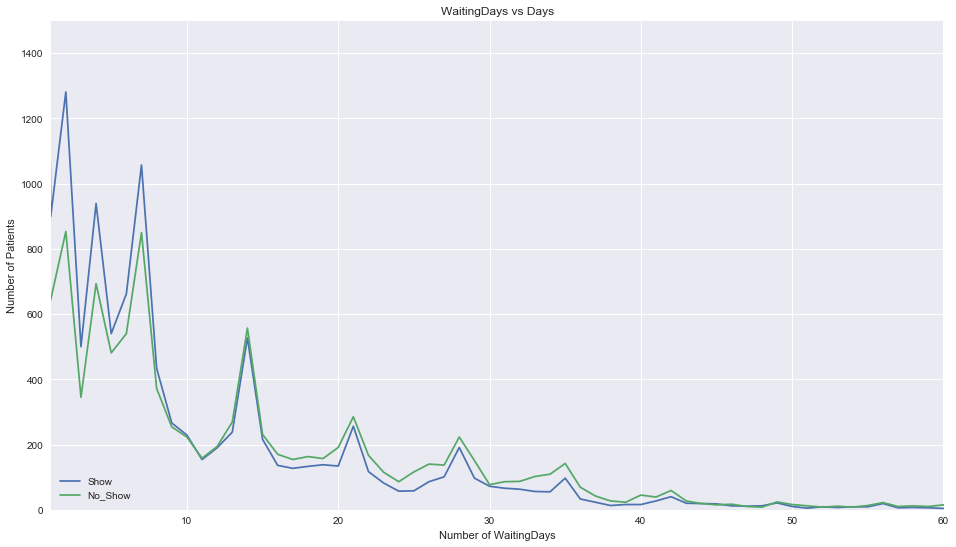

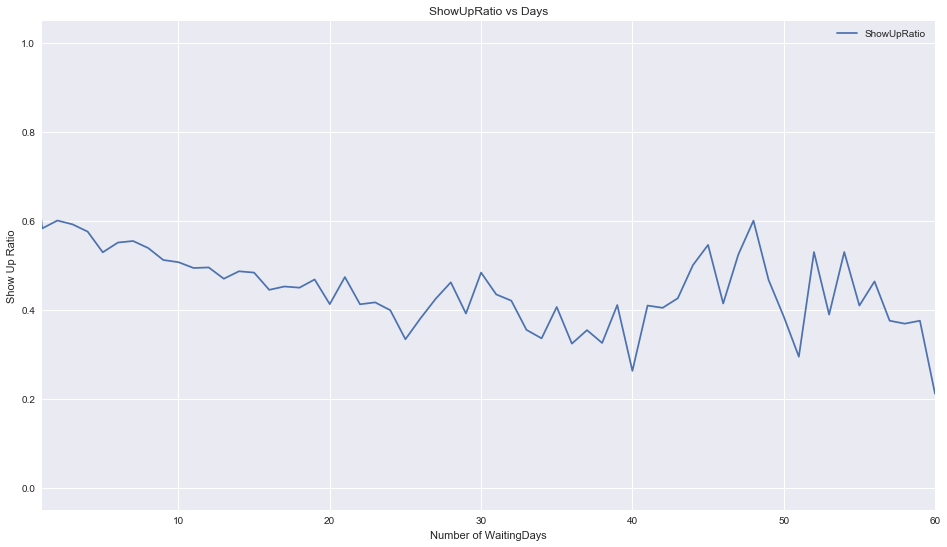

In [202]:
plotByAttribute(shownoshow_df,'WaitingDays',1500)

> When plotting both the _total ammount of Show and No-Show patients_ and the _ShowUpRatio_, we can see an increasing trend in the number of No_Shows and a drecreasing trend in the ShowUpRate

### 2)  How does _Age_ affect the appointments visit

> The expected outcome of both the Age and Show Up Ratio graph is the visualization of a trend across the ages of patients in the sample

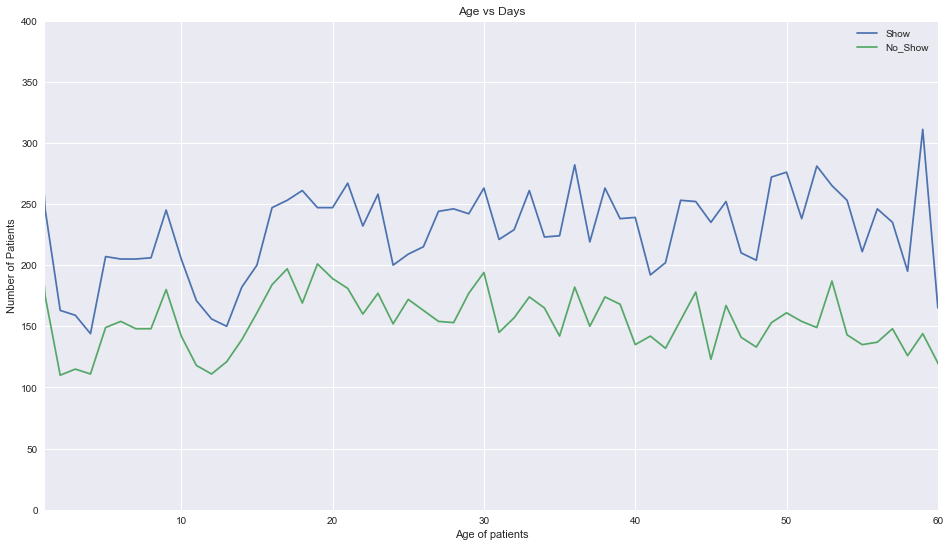

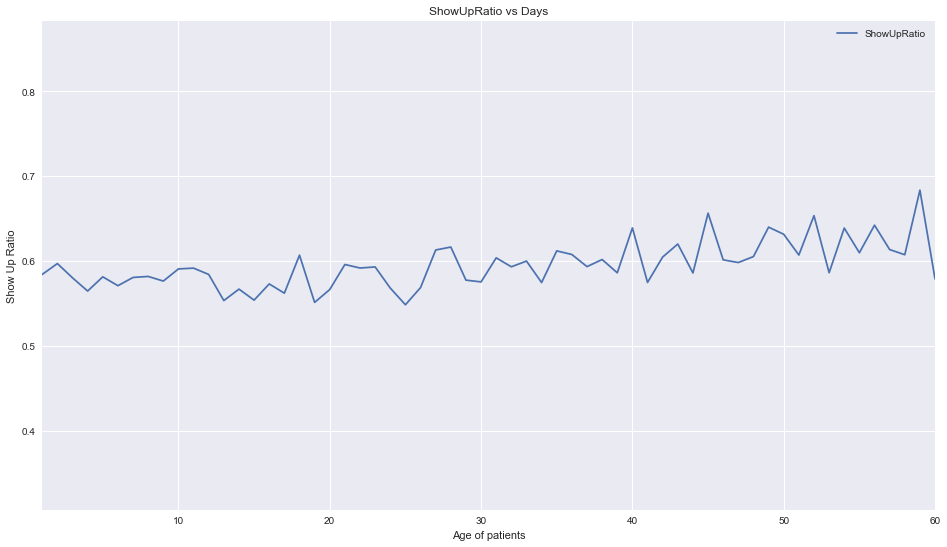

In [203]:
plotByAttribute(shownoshow_df,'Age',1500)

> In comparison with _Waiting Days_ chart, we can see a more flat trend of the Show Up Ratio that slowly increase as patients beocome 30 and older.

### 3)  How does _SMS_ affect the appointments visit ?

> In this section we will show a couple of graphs to understand how SMS reminders might affect the show up rate.

#### 3.1) General Pie Charts


In [262]:
def plotPiebyAttr(df,attr):
    dfgroup_sms = df.groupby(attr).count()
    dfgroup_sms['PatientId'].plot(kind='pie',autopct='%.2f', fontsize=20, figsize=(4, 4))
    
def plotBarbyAttr(df,attr,title):
    dfgroup_sms = df.groupby(attr).sum()
    plot = dfgroup_sms[['Show','No_Show']].plot.barh(stacked=True,title=title)
    plot.set_yticklabels(['No SMS','SMS'])

> **Always Show Patients** - The expected outcome of this chart is a comparison between those who received SMS and those who didn't to check if there is a relation between these two groups.

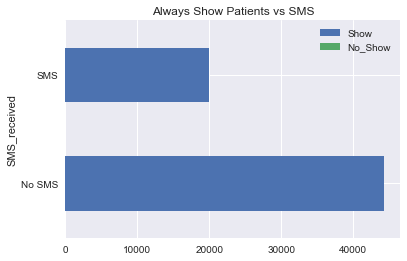

In [278]:
plotBarbyAttr(show_df,'SMS_received','Always Show Patients vs SMS')

> **Always no Show Patients** - The expected outcome of this chart is a comparison between those who received SMS and those who didn't to check if there is a relation between these two groups. We would expect less SMSs in this group, which is true after plotting and comparing against the previous chart.

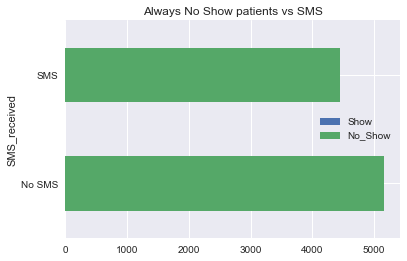

In [264]:
plotBarbyAttr(noshow_df,'SMS_received','Always No Show patients vs SMS')

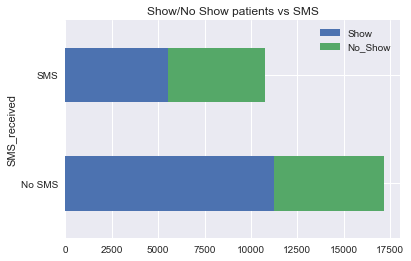

In [248]:
plotBarbyAttr(shownoshow_df,'SMS_received','Show/No Show patients vs SMS')

#### 3.2) Statistical Test to SMS impact ( Chi Square Test)

> Our null hypothesis states that people showing up to appointments is a random event and it does not depend on whether they receive or not a SMS
This test will be performend:
+   **Over Group I (always SHOW) and II (always NO SHOW) together (concatenated)**

>|        | SHOW | NO SHOW |
|--------|------|---------|
| SMS    |    19954  |       4450  |
| NO SMS |    44311  |     5169   |



In [ ]:
df_group12['Show'] = show_df.groupby('SMS_received').sum()['Show']
df_group12['No_Show'] =  noshow_df.groupby('SMS_received').sum()['No_Show']
chisqarray = np.array([df_group12['Show'],df_group12['No_Show']])
scs.chi2_contingency(chisqarray)


>+   **Over Group III (sometimes SHOW and NO SHOW)**

>|        | SHOW | NO SHOW |
|--------|------|---------|
| SMS    |    5517  |       5219  |
| NO SMS |    11253  |     5935    |







In [ ]:
df_group3 = shownoshow_df.groupby('SMS_received').sum()[['Show','No_Show']]
chisqarray = np.array([df_group3['Show'],df_group3['No_Show']])
scs.chi2_contingency(chisqarray)

> Both _chi squares_ values show results  of 875 and 546, therefore we can reject the null hypothesis and infere that SMS  messages do impact the show up rate.

#### 3.3) SMS and Waiting Days

#### Always SHOW and SMS by Waiting Days

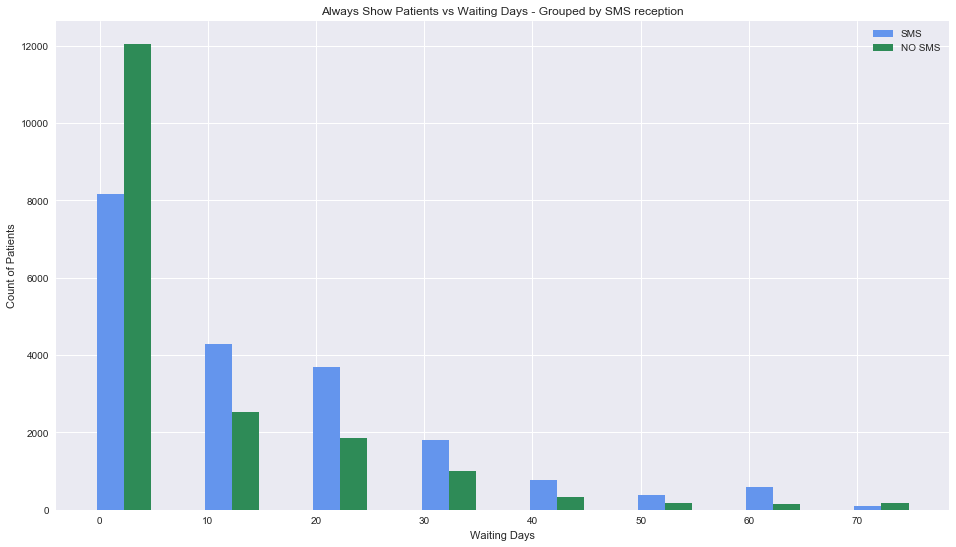

In [294]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(show_df.loc[show_df['SMS_received']==1]['WaitingDays'],bins=np.arange(1.0,90.0,10.0))
b_heights, b_bins = np.histogram(show_df.loc[show_df['SMS_received']==0]['WaitingDays'],bins=np.arange(1.0,90.0,10.0))#bins=a_bins)
width = (a_bins[1] - a_bins[0])/4

plta=ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
pltb=ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')

plt.legend([plta, pltb], ["SMS", "NO SMS"])

plt.title('Always Show Patients vs Waiting Days - Grouped by SMS reception')
ax.set_xlabel('Waiting Days')
ax.set_ylabel('Count of Patients')

fig.set_figheight(9)
fig.set_figwidth(16)

####  Always NO SHOW  and SMS by AGE

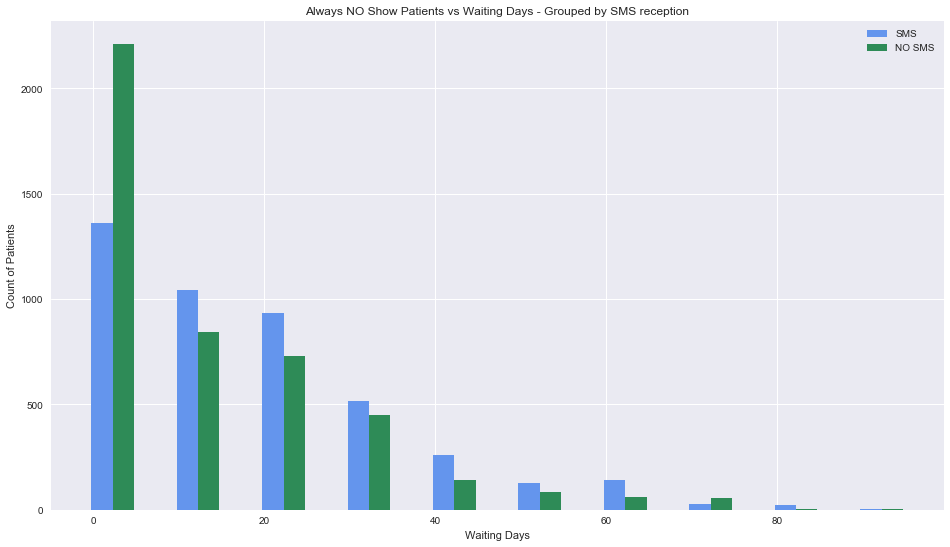

In [295]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(noshow_df.loc[noshow_df['SMS_received']==1]['WaitingDays'],bins=np.arange(1.0,110.0,10.0))
b_heights, b_bins = np.histogram(noshow_df.loc[noshow_df['SMS_received']==0]['WaitingDays'],bins=np.arange(1.0,110.0,10.0))#bins=a_bins)
width = (a_bins[1] - a_bins[0])/4

plta=ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
pltb=ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')

plt.legend([plta, pltb], ["SMS", "NO SMS"])

plt.title('Always NO Show Patients vs Waiting Days - Grouped by SMS reception')
ax.set_xlabel('Waiting Days')
ax.set_ylabel('Count of Patients')

fig.set_figheight(9)
fig.set_figwidth(16)

#### Show and No-Show with SMS  by AGE

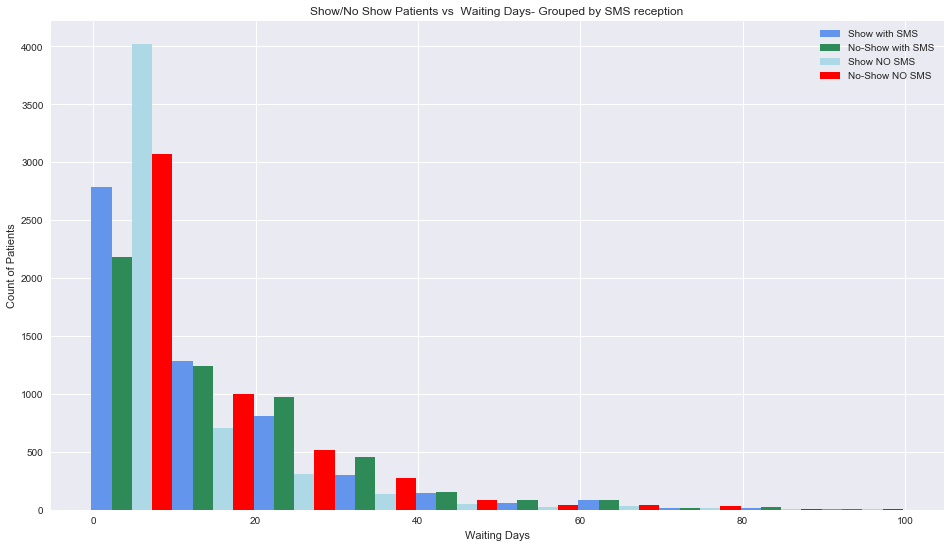

In [296]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(shownoshow_df.loc[(shownoshow_df['SMS_received']==1) & (shownoshow_df['Show']==1)]['WaitingDays'],bins=np.arange(1.0,110.0,10.0))
b_heights, b_bins = np.histogram(shownoshow_df.loc[(shownoshow_df['SMS_received']==1) & (shownoshow_df['Show']==0)]['WaitingDays'],bins=np.arange(1.0,110.0,10.0))#bins=a_bins)
c_heights, c_bins = np.histogram(shownoshow_df.loc[(shownoshow_df['SMS_received']==0) & (shownoshow_df['Show']==1)]['WaitingDays'],bins=np.arange(1.0,110.0,10.0))
d_heights, d_bins = np.histogram(shownoshow_df.loc[(shownoshow_df['SMS_received']==0) & (shownoshow_df['Show']==0)]['WaitingDays'],bins=np.arange(1.0,110.0,10.0))#bins=a_bins)

width = (a_bins[1] - a_bins[0])/4

plta=ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
pltb=ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')
pltc=ax.bar(c_bins[:-1]+2*width, c_heights, width=width, facecolor='lightblue')
pltd=ax.bar(d_bins[:-1]+3*width, d_heights, width=width, facecolor='red')

plt.legend([plta, pltb,pltc,pltd], ["Show with SMS", "No-Show with SMS","Show NO SMS","No-Show NO SMS"])
plt.title('Show/No Show Patients vs  Waiting Days- Grouped by SMS reception')
ax.set_xlabel('Waiting Days')
ax.set_ylabel('Count of Patients')

fig.set_figheight(9)
fig.set_figwidth(16)


> This bar chart shows how the impact of Waiting Days (larger than 10) increases the amount of NO SHOW without SMS over the SHOW with SMS. This last group should be later analyzed deeply to check if SMS can increase their show up ratio.

### 4)  How does _Neighbourhoods_ affect the appointments visit

In [267]:
#dfgroup = df.groupby(['WaitingDays','Neighbourhood'])['Show','No_Show'].sum()
def plotByNeighbourhood(df):
    
    dfgroup = df.groupby('Neighbourhood')['Show','No_Show'].sum()
    dfgroup['ShowUpRatio'] = 1*(dfgroup['Show'] / (dfgroup['Show'] + dfgroup['No_Show']))
    dfgroup['Total'] = dfgroup['Show'] + dfgroup['No_Show']
    #dfgroup = dfgroup.sort_values(by=['Total','ShowUpRatio'],ascending=[0,0])
    dfgroup = dfgroup.sort_values(by='Total',ascending=0)

    fig, ax = plt.subplots()
    ax2 = ax.twinx()

    dfgroup['ShowUpRatio'].plot(ax=ax,kind="line",rot=90,title='Show Up Rate and Neighbouhood Samples versus Neighbourhoods')
    dfgroup['Total'].plot(kind='bar',stacked=False,figsize=(16,9),ax=ax2, secondary_y=True)

    ax.legend(loc='best')
    

    

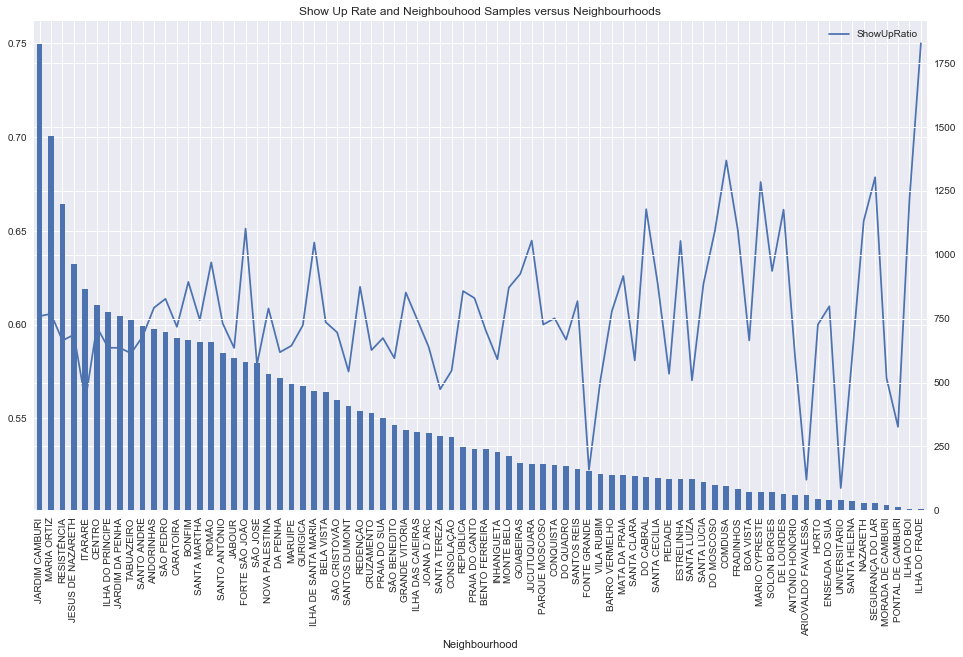

In [268]:
plotByNeighbourhood(shownoshow_df)

The bar chart shows the total of patients per neighbourhood of the _Show/No-Show_ dataframe. In the same chart the line graph displays a "flat" trend where no increase or decrease is shown.

<a id='conclusions'></a>
## Conclusions


> **Correction**
Required - The conclusion is missing the limitation of the dataset. You need to state what could be your future work or potential areas to explore. Were there some factors limiting your analysis. All this should be clearly stated

> The main highlights of the analysis are:

1) Larger waiting days show a decrease of the Show Up Ratio, bt no causality is demonstrated.

2) It is not clear, despite the Chi Square Test, how SMS might help people to show in their appointments. In the **Always NO SHOW and SMS by AGE**, patients without SMS are more than those with SMS. But that behaviour is not the same in the **Show and No-Show with SMS  by AGE**

3) Neighbourhoods show a high variability in the number of samples per each neighbourhood and therefore, when overlapped the Show Up rate there is no visible trend.

4) The scope of the dataset and its attributes is limited and lacks of important features such as:

      4.1) Distance from Patients to Hospital
   
      4.2) Public Transportation promixity versus car use
   
      4.3) Time of the Appointmen4
   
   Also a 100,000 records sample is not enough and more records would be needed to find a define pattern and the independent variables that cause patients to skip or miss appointments.
   
5) Additional layers such as population of each neighbourhood and socioeconomic features would help to the analysis.
6) The best approach to analyze the No Show scenario is to consider the location feature in the dataset: where patients are, where hospital are and hoe reachable are between them.